# Task 1.5: Dimensionality Reduction

This notebook implements `reduce_trajectories()` a function that takes multiple token trajectories (768-dim embeddings per layer) and projects them down to 2D using PCA, so that we can visualize how tokens move through the model's representation space across layers. 

PCA (Principal Component Analysis) is a technique for reducing high-dimensional data down to fewer dimensions while preserving as much of the original structure as possible.

**Key idea:** All tokens share the same PCA space, so their 2D trajectories are directly comparable to each other.

In [1]:
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

model = HookedTransformer.from_pretrained("gpt2-small")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


## `get_token_trajectory()` (from Task 1.4)

Returns the residual stream embedding for one token at every layer — the raw 768-dim vectors we'll feed into PCA.

In [2]:
def get_token_trajectory(text: str, token_index: int) -> list[dict]:
    """Returns the residual stream vector for one token at each layer."""
    _, cache = model.run_with_cache(text)
    n_layers = model.cfg.n_layers  # 12 for GPT-2 small
    trajectory = []
    for layer in range(n_layers):
        embedding = cache["resid_post", layer][0, token_index, :]  # shape (768,)
        trajectory.append({
            "layer": layer,
            "embedding": embedding.tolist()  # convert tensor to list
        })
    return trajectory

## `reduce_trajectories()` — Joint PCA to 2D

Takes a dict of `{token_index: trajectory}` and reduces all embeddings together into one shared 2D PCA space.

- **Input:** `{token_index: [{"layer": int, "embedding": [768 floats]}, ...]}`
- **Output:** `{token_index: [{"layer": int, "x": float, "y": float}, ...]}`

In [3]:
def reduce_trajectories(trajectories: dict[int, list]) -> dict[int, list[dict]]:
    """
    Input:  {token_index: [768-dim embedding per layer]}
    Output: {token_index: [{layer, x, y} per layer]}

    All tokens share the same PCA space so trajectories are comparable.
    """
    # Collect ALL embeddings into one matrix for joint PCA
    all_embeddings = []
    labels = []  # (token_index, layer) pairs
    for token_idx, layers in trajectories.items():
        for layer_data in layers:
            all_embeddings.append(layer_data["embedding"])
            labels.append((token_idx, layer_data["layer"]))

    all_embeddings = np.array(all_embeddings)
    pca = PCA(n_components=2)
    coords_2d = pca.fit_transform(all_embeddings)

    # Reconstruct per-token trajectories with 2D coordinates
    result = {}
    for i, (token_idx, layer) in enumerate(labels):
        if token_idx not in result:
            result[token_idx] = []
        result[token_idx].append({
            "layer": layer,
            "x": float(coords_2d[i, 0]),
            "y": float(coords_2d[i, 1])
        })

    print(f"PCA explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")
    print(f"Total variance captured: {sum(pca.explained_variance_ratio_):.3f}")
    return result, pca

## Test: Reduce trajectories for 3 tokens in "The cat sat on the mat"

We'll track `" cat"` (index 2), `" sat"` (index 3), and `" mat"` (index 6) — three content words from the same sentence.

In [4]:
text = "The cat sat on the mat"

# Check tokenization first
tokens = model.to_str_tokens(text)
print("Tokens:", list(enumerate(tokens)))

Tokens: [(0, '<|endoftext|>'), (1, 'The'), (2, ' cat'), (3, ' sat'), (4, ' on'), (5, ' the'), (6, ' mat')]


In [5]:
# Extract trajectories for 3 content tokens
# index 2 = " cat", index 3 = " sat", index 6 = " mat"
token_indices = {2: " cat", 3: " sat", 6: " mat"}

raw_trajectories = {
    idx: get_token_trajectory(text, idx)
    for idx in token_indices
}

print(f"Collected trajectories for {len(raw_trajectories)} tokens, {len(list(raw_trajectories.values())[0])} layers each.")

Collected trajectories for 3 tokens, 12 layers each.


In [6]:
# Apply joint PCA
reduced, pca = reduce_trajectories(raw_trajectories)

# Inspect the output for one token
print("\n2D trajectory for ' cat' (index 2):")
for point in reduced[2]:
    print(f"  Layer {point['layer']:2d} → x={point['x']:.4f}, y={point['y']:.4f}")

PCA explained variance ratio: PC1=0.703, PC2=0.094
Total variance captured: 0.796

2D trajectory for ' cat' (index 2):
  Layer  0 → x=-67.8518, y=9.4001
  Layer  1 → x=-71.1444, y=11.3097
  Layer  2 → x=-65.8493, y=17.9552
  Layer  3 → x=-61.8866, y=23.7411
  Layer  4 → x=-59.1188, y=27.9096
  Layer  5 → x=-54.6031, y=33.2084
  Layer  6 → x=-43.7760, y=42.3728
  Layer  7 → x=-26.3883, y=55.1057
  Layer  8 → x=-6.8434, y=72.0746
  Layer  9 → x=24.4738, y=89.0232
  Layer 10 → x=102.4447, y=116.2768
  Layer 11 → x=214.9425, y=95.8500


## Visualization: Token Trajectories Through 12 Layers

Each token's path is a **connected sequence of dots** — earlier layers are smaller and more transparent, later layers are larger and more opaque. Layer numbers are annotated along the `" cat"` path for reference.

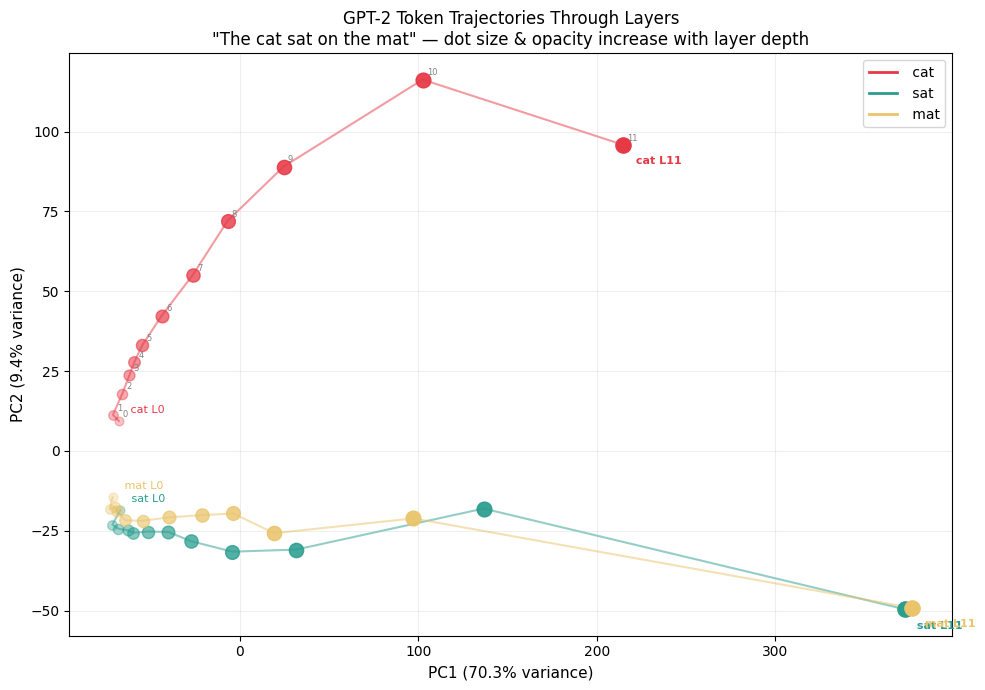

Plot saved to token_trajectories_pca.png


In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

colors = ["#E63946", "#2A9D8F", "#E9C46A"]  # red, teal, yellow
n_layers = model.cfg.n_layers

for color, (token_idx, label) in zip(colors, token_indices.items()):
    points = reduced[token_idx]
    xs = [p["x"] for p in points]
    ys = [p["y"] for p in points]

    # Draw connecting line
    ax.plot(xs, ys, color=color, linewidth=1.5, alpha=0.5, zorder=1)

    # Draw dots — smaller/transparent at early layers, larger/opaque at later layers
    for layer_idx, (x, y) in enumerate(zip(xs, ys)):
        alpha = 0.3 + 0.7 * (layer_idx / (n_layers - 1))
        size = 40 + 80 * (layer_idx / (n_layers - 1))
        ax.scatter(x, y, color=color, s=size, alpha=alpha, zorder=2)

    # Label start and end
    ax.annotate(f"{label} L0", (xs[0], ys[0]),
                fontsize=8, color=color,
                xytext=(6, 6), textcoords="offset points")
    ax.annotate(f"{label} L11", (xs[-1], ys[-1]),
                fontsize=8, color=color, fontweight="bold",
                xytext=(6, -14), textcoords="offset points")

# Annotate layer numbers along the ' cat' path
for point in reduced[2]:
    ax.annotate(str(point["layer"]),
                (point["x"], point["y"]),
                fontsize=6, color="gray",
                xytext=(3, 3), textcoords="offset points")

var1, var2 = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({var1:.1%} variance)", fontsize=11)
ax.set_ylabel(f"PC2 ({var2:.1%} variance)", fontsize=11)
ax.set_title(
    'GPT-2 Token Trajectories Through Layers\n'
    f'"{text}" — dot size & opacity increase with layer depth',
    fontsize=12
)
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=c, linewidth=2, label=l)
        for c, l in zip(colors, token_indices.values())
    ],
    fontsize=10
)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("token_trajectories_pca.png", dpi=150, bbox_inches="tight")
plt.show()
print("Plot saved to token_trajectories_pca.png")

## What to observe

- Each token starts at a distinct location (layer 0 = token embedding + positional encoding)
- As depth increases, tokens **move through the 2D space** — this reflects the model refining their contextual meaning
- `" cat"`, `" sat"`, and `" mat"` are rhyming words with similar syntactic roles — watch whether they converge or stay separated
- The PCA explained variance tells you how much of the 768D structure is captured in this 2D view

## Bonus: UMAP comparison

UMAP is a non-linear alternative to PCA — it preserves local neighborhood structure better, often producing cleaner clusters. Run `pip install umap-learn` first.

In [ ]:
try:
    import umap

    def reduce_trajectories_umap(trajectories: dict[int, list]) -> dict[int, list[dict]]:
        """Same as reduce_trajectories() but uses UMAP instead of PCA."""
        all_embeddings = []
        labels = []
        for token_idx, layers in trajectories.items():
            for layer_data in layers:
                all_embeddings.append(layer_data["embedding"])
                labels.append((token_idx, layer_data["layer"]))

        all_embeddings = np.array(all_embeddings)
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords_2d = reducer.fit_transform(all_embeddings)

        result = {}
        for i, (token_idx, layer) in enumerate(labels):
            if token_idx not in result:
                result[token_idx] = []
            result[token_idx].append({
                "layer": layer,
                "x": float(coords_2d[i, 0]),
                "y": float(coords_2d[i, 1])
            })
        return result

    reduced_umap = reduce_trajectories_umap(raw_trajectories)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, (data, title) in zip(axes, [
        (reduced, "PCA"),
        (reduced_umap, "UMAP")
    ]):
        for color, (token_idx, label) in zip(colors, token_indices.items()):
            points = data[token_idx]
            xs = [p["x"] for p in points]
            ys = [p["y"] for p in points]
            ax.plot(xs, ys, color=color, linewidth=1.5, alpha=0.5)
            for layer_idx, (x, y) in enumerate(zip(xs, ys)):
                alpha = 0.3 + 0.7 * (layer_idx / (n_layers - 1))
                size = 40 + 80 * (layer_idx / (n_layers - 1))
                ax.scatter(x, y, color=color, s=size, alpha=alpha)
            ax.annotate(label, (xs[-1], ys[-1]), fontsize=9, color=color,
                        xytext=(5, 5), textcoords="offset points", fontweight="bold")
        ax.set_title(f"{title} projection", fontsize=12)
        ax.grid(True, alpha=0.2)

    plt.suptitle(f'PCA vs UMAP — Token Trajectories Through GPT-2 Layers\n"{text}"', fontsize=13)
    plt.tight_layout()
    plt.savefig("token_trajectories_pca_vs_umap.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Comparison plot saved.")

except ImportError:
    print("umap-learn not installed. Run: pip install umap-learn")
    print("Skipping UMAP comparison.")